In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as ss

mapping = pd.read_csv("../sample_data/trial_6/mapping.csv")
edges = pd.read_csv('../sample_data/trial_6/edges.csv')
ts = pd.read_csv("../sample_data/trial_6/ts.csv")
g = nx.from_pandas_edgelist(
    edges, 
    source="src", 
    target="dst",
    edge_attr="weight",
    create_using=nx.DiGraph
)

Name: 
Type: DiGraph
Number of nodes: 2183
Number of edges: 54539
Average in degree:  24.9835
Average out degree:  24.9835


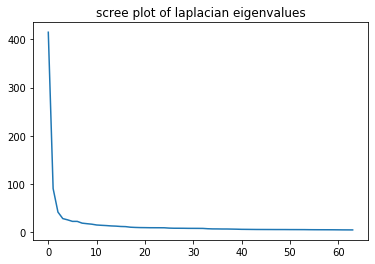

In [2]:
print(nx.info(g))

L = nx.laplacian_matrix(nx.Graph(g))
k = 64
w, v = ss.linalg.eigsh(L, k=k)
plt.title("scree plot of laplacian eigenvalues")
plt.plot(np.arange(k), w[::-1])
plt.show()

In [3]:
def laplacian_embedding(g, dim):
    L = nx.laplacian_matrix(g)
    w, v = ss.linalg.eigsh(L, k=dim+1)
    return np.divide(v[:, :-1], np.sqrt(w[:-1]))[::-1]

In [4]:
from sklearn import linear_model, metrics

def rmse(X, y):
    return np.sqrt(metrics.mean_squared_error(X, y))

def mape(X, y):
    return abs(np.divide(y - X, y)).sum()/y.size

def summarize(y, y_pred):
    print(f"rmse: {rmse(y, y_pred)}")
    print(f"mape: {mape(y, y_pred)}")
    plt.figure(figsize=(16, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.plot(y[i].T, label="y")
        plt.plot(y_pred[i].T, label="$\hat{y}$")
        plt.legend()
    plt.show()

In [5]:
# fill missing days with very small values
X = ts.iloc[:,1:].fillna(1e-6).values
T = X.shape[1]
window_size = 7

# Create a new matrix for every row that is matrix of size (T//window_size, window_size)
indexer = (
    np.arange(window_size).reshape(1, -1) 
    + window_size*np.arange(T//window_size).reshape(-1, 1)
)

# A pane is made up of many windows
panes = X[:,indexer]
print(panes.shape)

end=12

# concatenate 4*3 windows, or 3 months of data, for the training data
train = panes[:,:end-2,:].reshape(panes.shape[0],-1)

# the test data is the final week
test = panes[:,end,:]

# we benchmark this against using the previous week's day
validate = panes[:,end-1,:]

(1247, 86, 7)


In [6]:
test.mean(axis=1).shape

(1247,)

rmse: 414.0643700453822
mape: 2367396.1223281072


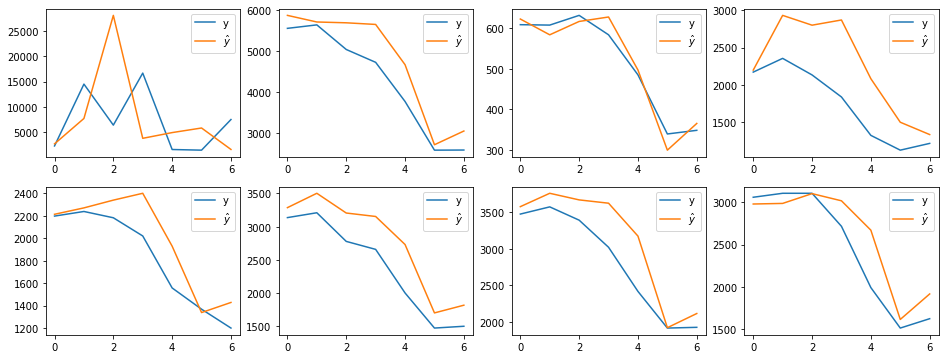

In [7]:
summarize(test, validate)

rmse: 326.1650183858846
mape: 789208.6362436761


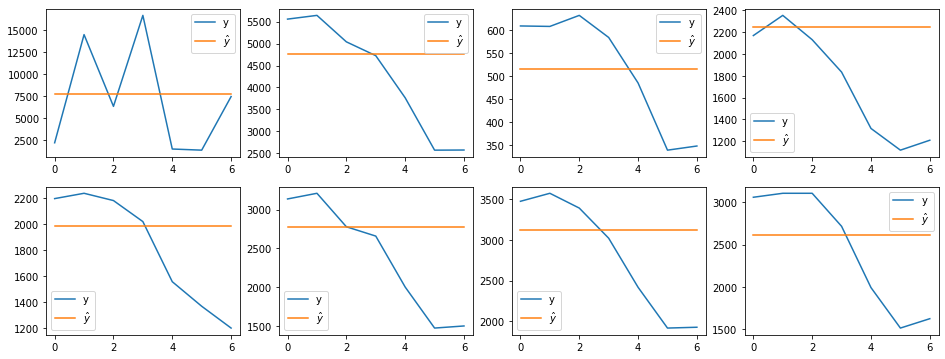

In [8]:
summarize(test, (np.ones(test.shape).T*validate.mean(axis=1)).T)

rmse: 1855.3444259746125
mape: 1.5795594076961144


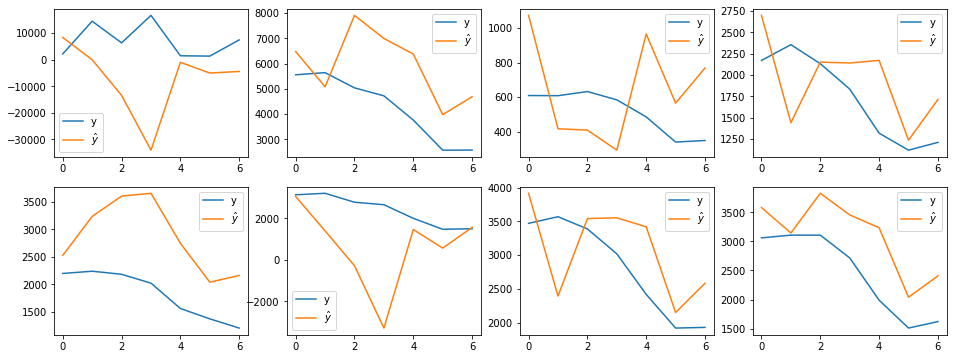

In [9]:
model = linear_model.LinearRegression()
model.fit(train, validate)
test_X = np.hstack([train, validate])[:,7:]
summarize(test, model.predict(test_X))

rmse: 2014.7610997594018
mape: 1.5990054020161877


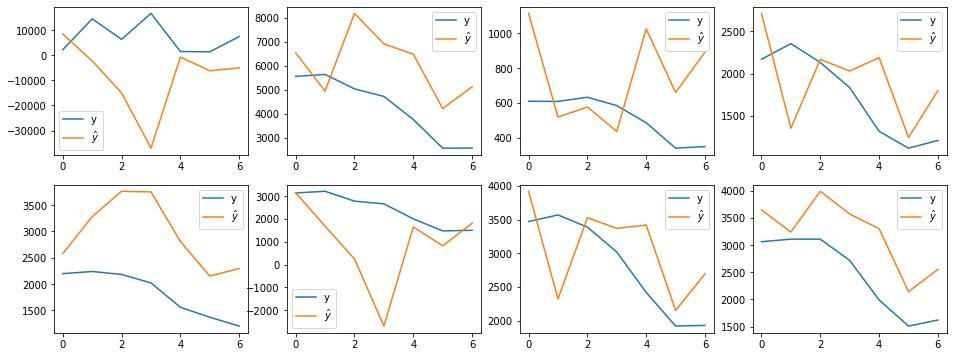

In [10]:
model = linear_model.Ridge(alpha=0)
model.fit(train, validate, ts.merge(mapping).pagerank)
summarize(test, model.predict(test_X))

rmse: 1850.46613567638
mape: 1.453241457934328


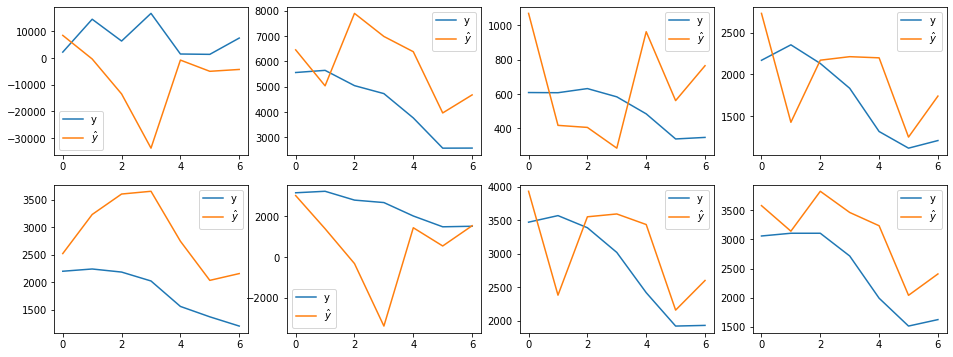

In [11]:
# Linear regression using graph features
emb = laplacian_embedding(nx.subgraph(nx.Graph(g), ts.id), 16)
model = linear_model.LinearRegression()
model.fit(np.hstack([train, emb]), validate)
summarize(test, model.predict(np.hstack([test_X, emb])))